In [1]:
import keras
import random 
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from skimage.io import imread
from keras import backend as K
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras import regularizers, optimizers
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

Using TensorFlow backend.
C:\Users\Nustian16\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Nustian16\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Nustian16\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Nustian16\anaconda3\lib\site-packages\tensorflow\python\fra

In [2]:
def image_generator(files, batch_size=32):
    from skimage.io import imread
    from random import sample, choice
    while True:
        batch_files = sample(files, batch_size)
        batch_Y = []
        batch_X = []
        for idx, input_path in enumerate(batch_files):
            image = np.array(imread(input_path), dtype=float)  
            #image[:,:,0]= (image[:,:,0]-image[:,:,0].min())/(image[:,:,0].max()-image[:,:,0].min())
            #image[:,:,1]= (image[:,:,1]-image[:,:,1].min())/(image[:,:,1].max()-image[:,:,1].min())
            temp = input_path.split('/')[-1]
            Y = list(df.loc[temp])
            batch_Y += [Y]
            batch_X += [image]
        X = np.array(batch_X)
        Y = np.array(batch_Y)
        yield(X, Y)

In [3]:
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

def build_callbacks():
    checkpointer = ModelCheckpoint(filepath="../models/ben_data_vgg_s1.h5", monitor='val_f1', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=4, mode='max')
    early = keras.callbacks.EarlyStopping(monitor='val_f1', min_delta=1e-4, patience=15, mode='max')
    csv = keras.callbacks.CSVLogger('../logs/ben_data_vgg_s1.csv', separator=',')
    callbacks = [checkpointer, reduce, early, csv]
    return callbacks

In [4]:
files = glob('/scratch/mrkhalid/ben_data'+"/**/**/**/*.tif")
print('Total no. of images ' + str(len(files)))
for i in range(100):
    random.shuffle(files)
ne = len(files)
train_files = files[:int(.7*ne)]
val_files = files[int(.7*ne):int(.85*ne)]
test_files = files[int(.85*ne):ne]
print('Training Dataset Size ' + str(len(train_files)))
print('Validation Dataset Size ' + str(len(val_files)))
print('Test Dataset Size ' + str(len(test_files)))

Total no. of images 0
Training Dataset Size 0
Validation Dataset Size 0
Test Dataset Size 0


In [ ]:
df = pd.read_csv(r'/scratch/mrkhalid/annotated.csv')
df['ID'] = df['ID'] + '.tif'
df.set_index("ID", inplace=True)
train_generator = image_generator(train_files, batch_size=32)
val_generator = image_generator(val_files, batch_size=32)
test_generator = image_generator(test_files, batch_size=32)

In [5]:
model = Sequential()
model.add(BatchNormalization(input_shape=(120,120,12)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(units=19, activation="sigmoid"))
model.compile(optimizers.adam(), loss="binary_crossentropy", metrics=['accuracy', recall, precision, f1])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
train_steps = len(train_files) // 32
val_steps = len(val_files) // 32
test_steps =len(test_files) // 32
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    epochs=100,
                    callbacks = build_callbacks(),
                    use_multiprocessing=True,
                    max_queue_size = 512,
                    workers=64
                    )

Epoch 1/100


/home/mrkhalid/miniconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


3120/5556 [===============>..............] - ETA: 21:15 - loss: 0.2675 - acc: 0.8812 - recall: 0.4528 - precision: 0.6780 - f1: 0.5406

In [ ]:
loss, acc, rec, prec, f1 = model.evaluate_generator(test_generator,steps=test_steps)
print(loss)
print(acc)
print(rec)
print(prec)
print(f1)

In [6]:
model.load_weights('../models/ben_data_vgg_s1_s2.h5')

In [10]:
from skimage.io import imread
from skimage.transform import resize
files = glob('../data'+'/**'+'/*.tif')
for f in files:
    image = np.array(imread(f), dtype=float)  
    img = np.reshape(image, (1, 120, 120, 12))
    r=model.predict(img)
    r[r>=.5]=1
    r[r<.5]=0
    print(np.where(r==1)[1])

[18]
[ 6  9 10 13 17]
[18]
[ 6  9 13]
[ 9 10]
[2 6]
[ 9 10 13]
[4 9]
[ 9 10 17]
[ 9 10]


In [17]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv('../logs/ben_data_vgg_s1_s2.csv')

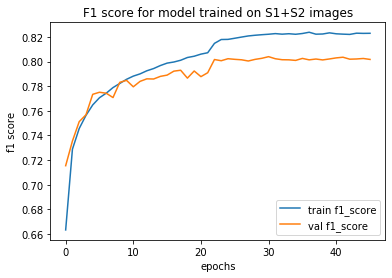

In [18]:
plt.plot(df['f1'], label='train f1_score')
plt.plot(df['val_f1'], label='val f1_score')
plt.xlabel('epochs')
plt.ylabel('f1 score')
plt.title('F1 score for model trained on S1+S2 images')
plt.legend(loc="lower right")
plt.savefig('../plots/f1_score/ben_data_vgg_s1_s2.png')

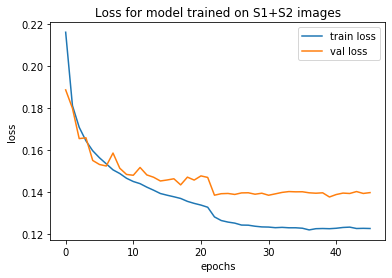

In [20]:
plt.plot(df['loss'], label='train loss')
plt.plot(df['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss for model trained on S1+S2 images')
plt.legend(loc="upper right")
plt.savefig('../plots/loss/ben_data_vgg_s1_s2.png')